Работа с временными рядами.
    
Известно ежемесячное число смертей в результате несчастного случая в США с января 1973 по декабрь 1978, необходимо построить прогноз на следующие 2 года.

In [ ]:
# Ksenia
# 12/02/24
# v.01

In [76]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs
import matplotlib.pyplot as plt
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [17]:
data = pd.read_csv('accidental-deaths-in-usa-monthly.csv', sep=',')

Text(0, 0.5, 'Accidental deaths')

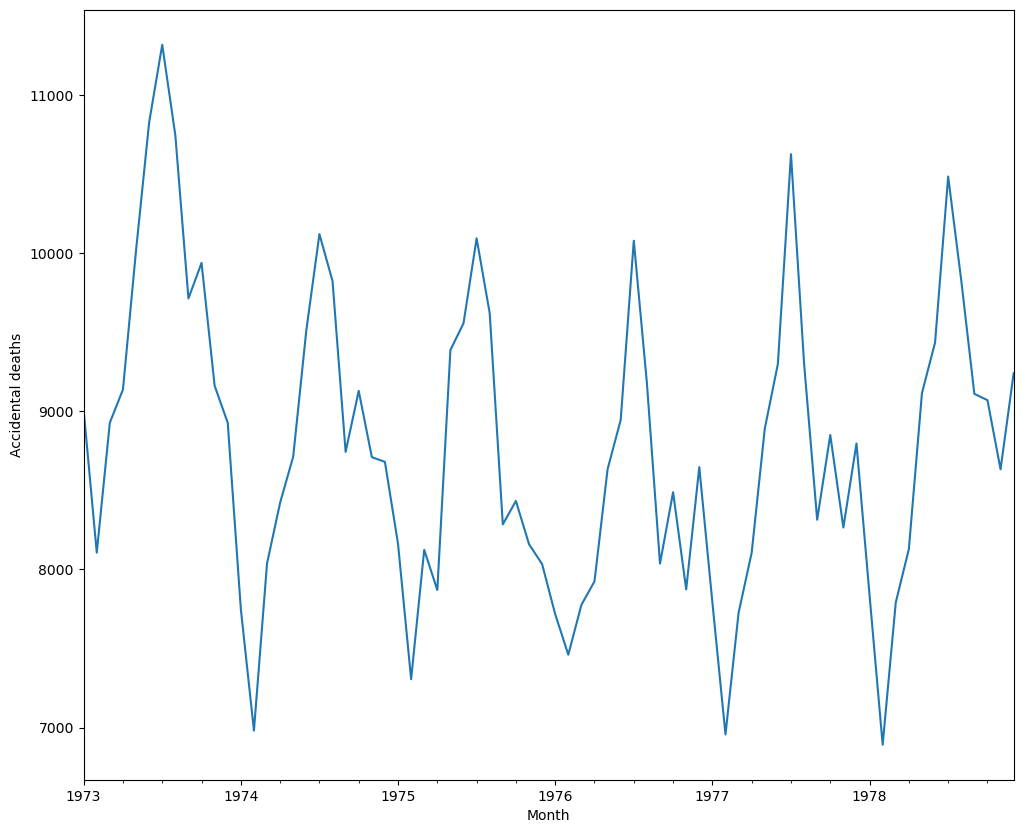

In [21]:
deaths = pd.read_csv('accidental-deaths-in-usa-monthly.csv',
                   index_col=['Month'], parse_dates=['Month'])
deaths.rename(columns={'Accidental deaths in USA: monthly, 1973 ? 1978': 'num_deaths'}, inplace=True)
deaths['num_deaths'].plot()
plt.ylabel('Accidental deaths')

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.102481


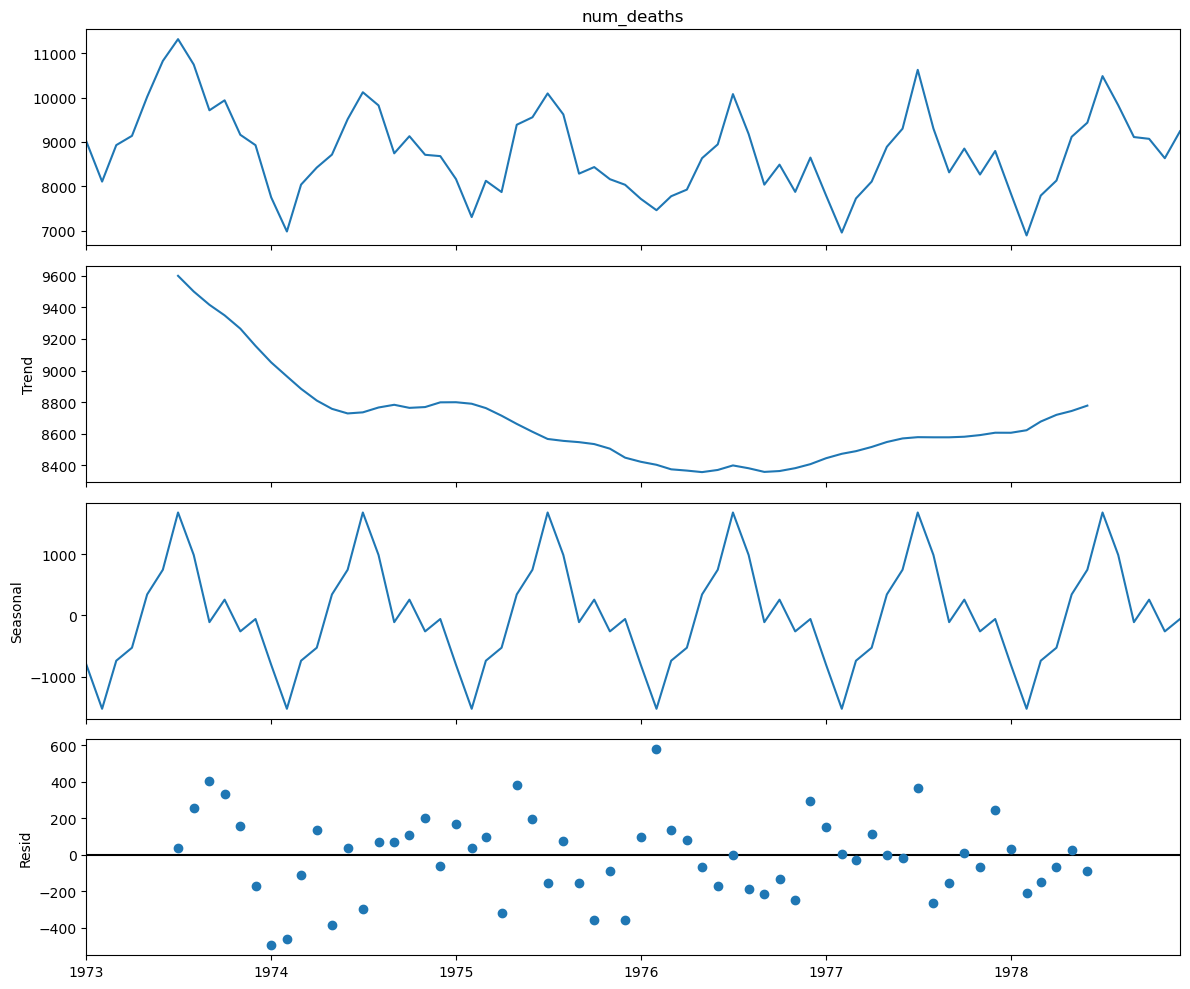

In [22]:
sm.tsa.seasonal_decompose(deaths['num_deaths']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(deaths['num_deaths'])[1])

In [23]:
sm.tsa.stattools.adfuller(deaths['num_deaths'])

(-2.5557984096356816,
 0.1024812205686505,
 12,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 870.8496020346796)

## Избавляемся от нестационарности и строим SARIMA

In [33]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        #Расширенный тест единичного корня Дики-Фуллера.
        #Расширенный тест Дики-Фуллера можно использовать для проверки единичного корня в одномерном процессе при наличии последовательной корреляции.


        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.102481


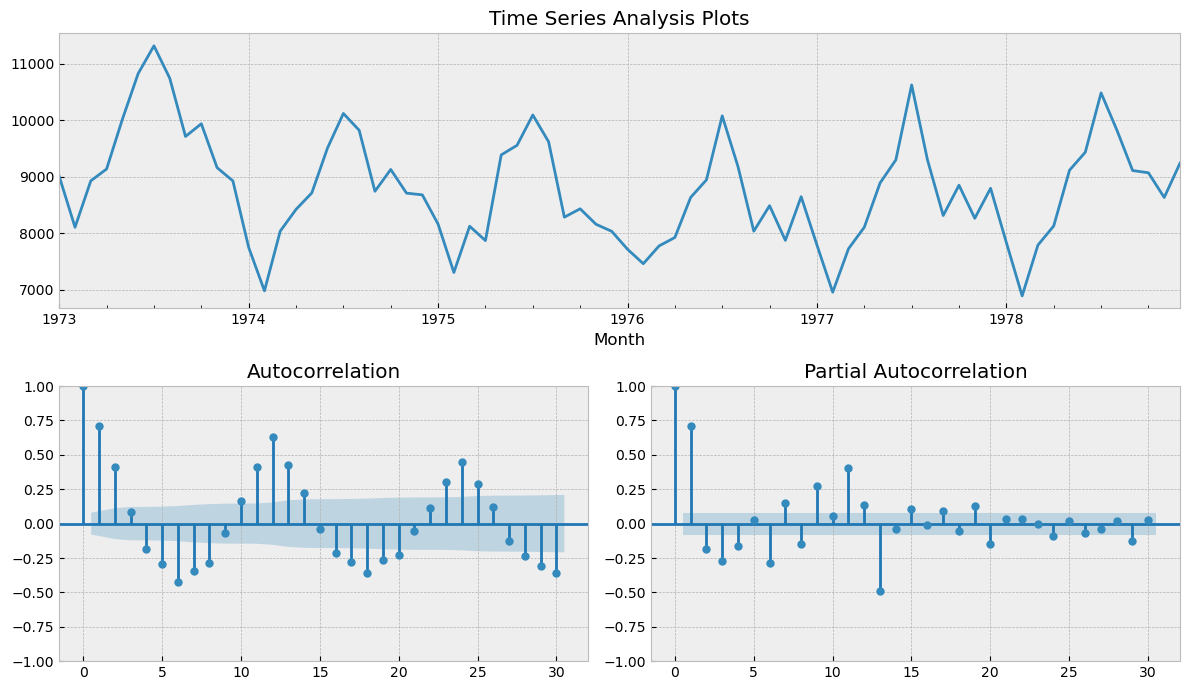

In [42]:
tsplot(deaths['num_deaths'], lags=30)

Критерий Дики-Фуллера: p=0.086943
Оптимальный параметр преобразования Бокса-Кокса: -0.275376


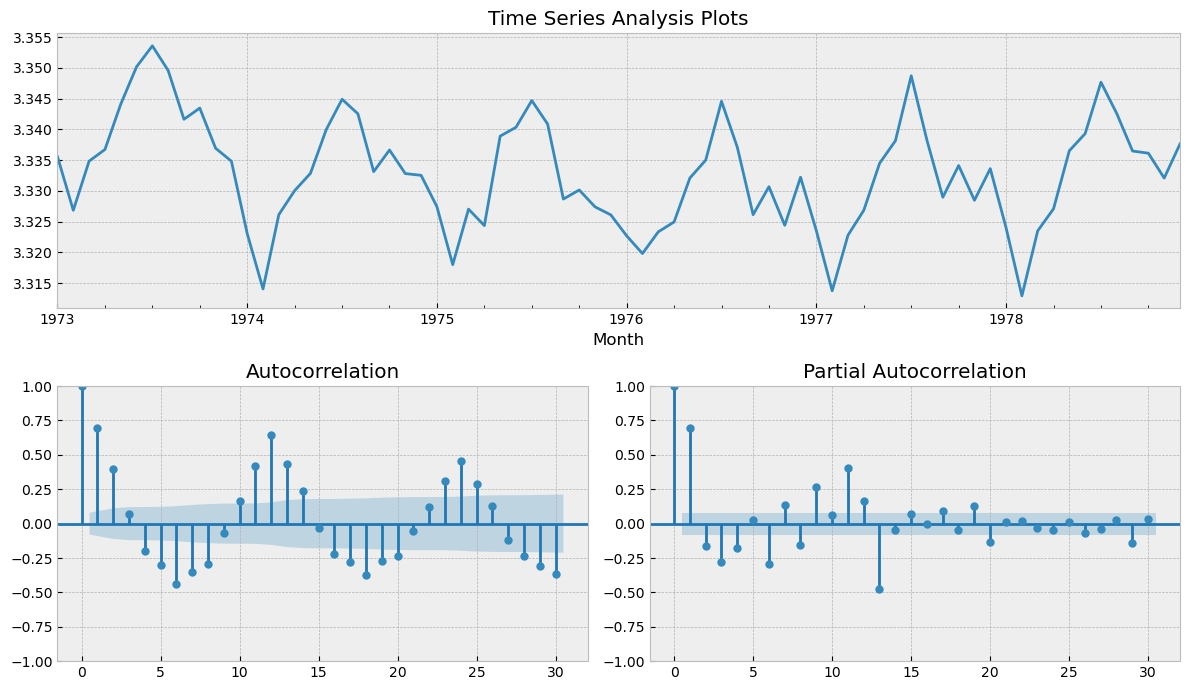

In [41]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


data = deaths.copy()
data['num_deaths'], lmbda = scs.boxcox(data.num_deaths+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.num_deaths, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

In [48]:
data

,num_deaths
Month,
1973-01-01,3.335551
1973-02-01,3.326840
1973-03-01,3.334833
1973-04-01,3.336716
1973-05-01,3.344083
...,...
1978-08-01,3.342564
1978-09-01,3.336476
1978-10-01,3.336118


вроде лучше исходя из кристерия Дики-Фуллера , но по-прежнему не отвергает гипотезу о нестационарности ряда. А автокорреляционная функция явно намекает на сезонность в получившемся ряде. Возьмём сезонные разности:

Month
1974-02-01   -0.000117
1974-03-01    0.001564
1974-04-01    0.000767
1974-05-01   -0.001728
1974-06-01    0.000398
Name: num_deaths_box, dtype: float64
Критерий Дики-Фуллера: p=0.000000


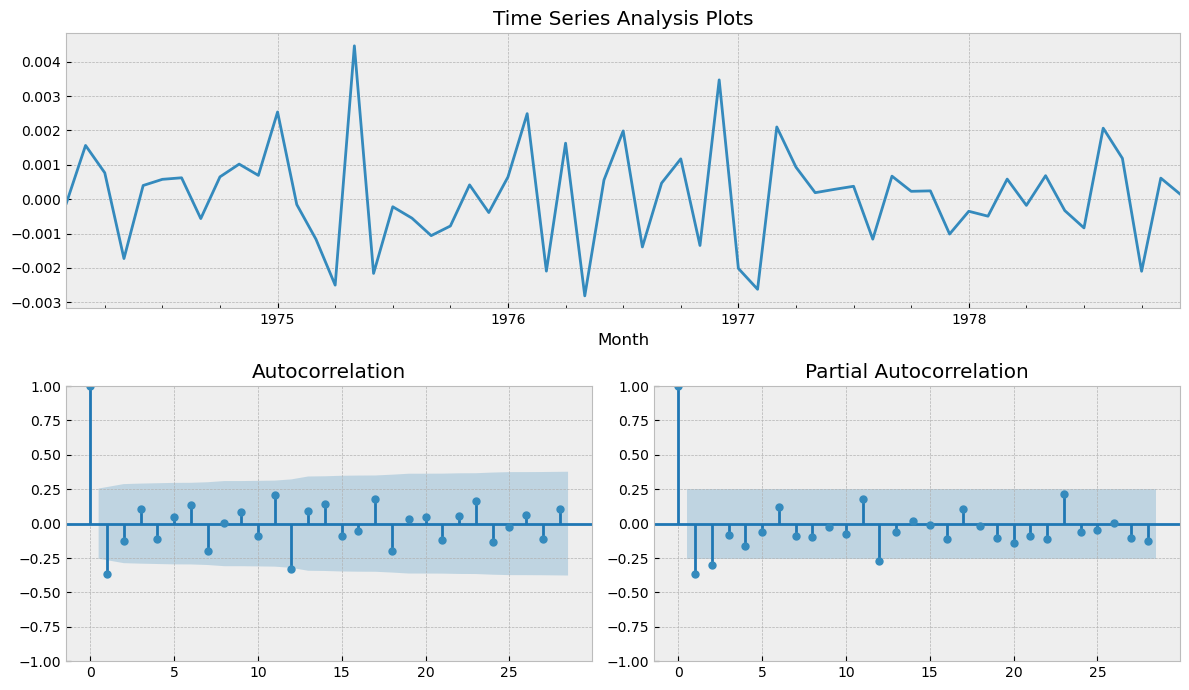

In [140]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
        
        plt.tight_layout()
    return

# Преобразование Бокса-Кокса для стабилизации дисперсии
data['num_deaths_box'], lmbda = scs.boxcox(data['num_deaths'] + 1)  # +1 для избежания нулевых значений

# Вычисление сезонной разности для устранения сезонности
seasonal_diff = data['num_deaths_box'].diff(12)

# Вычисление первых разностей для устранения тренда
first_diff = seasonal_diff.diff()

# Удаление строк с пропущенными значениями (NaN)
first_diff = first_diff.dropna()

# Вывод первых нескольких строк преобразованных данных
print(first_diff.head())

# Проверка стационарности с помощью критерия Дики-Фуллера
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(first_diff)[1])

# Вывод графика tsplot
tsplot(first_diff, lags=28)

c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   72
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 12)   Log Likelihood                 295.115
Date:                              Mon, 12 Feb 2024   AIC                           -578.231
Time:                                      01:27:34   BIC                           -564.571
Sample:                                  01-01-1973   HQIC                          -572.793
                                       - 12-01-1978                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4905      0.490      1.001      0.317      -0.470       1.451
ar.L1          0.58

c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\ProgramData\anacon

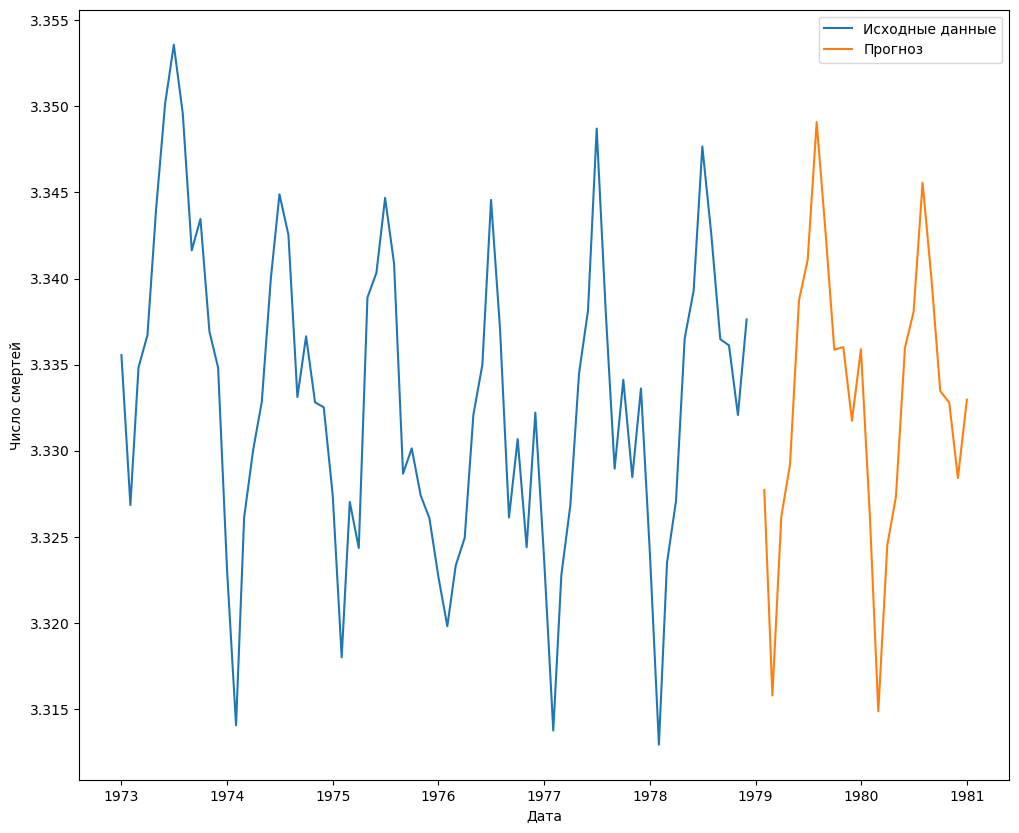

In [141]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Выбор столбца с числом смертей
deaths = data['num_deaths']

# Автоматический подбор параметров модели ARIMA
model = auto_arima(deaths, seasonal=True, m=12)

# Получение оптимальных параметров модели
print(model.summary())

# Обучение модели SARIMA с использованием оптимальных параметров
sarima_model = SARIMAX(deaths, order=model.order, seasonal_order=model.seasonal_order)
sarima_result = sarima_model.fit()

# Прогнозирование на следующие 24 месяца
forecast = sarima_result.forecast(steps=24)

# Визуализация прогноза
plt.plot(deaths.index, deaths, label='Исходные данные')
plt.plot(pd.date_range(start=deaths.index[-1], periods=25, freq='M')[1:], forecast, label='Прогноз')
plt.xlabel('Дата')
plt.ylabel('Число смертей')
plt.legend()
plt.show()

Исходя из этих результатов, модель SARIMAX хорошо подходит для моделирования временных рядов числа смертей в результате несчастных случаев в США с января 1973 года по декабрь 1978 года. Однако есть некоторые признаки, которые могут указывать на возможность дальнейшего улучшения модели, такие как возможное присутствие автокорреляции в остатках и отклонение от нормального распределения.

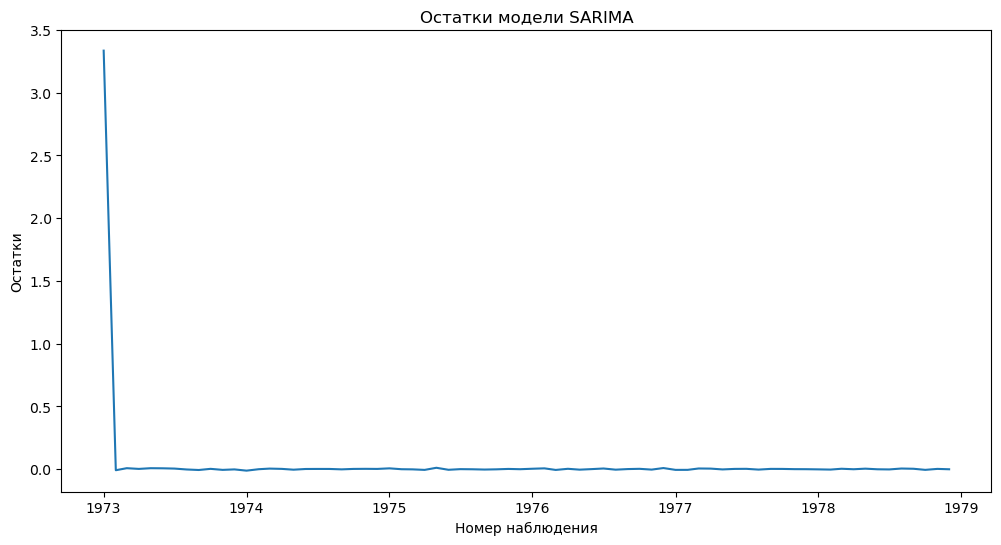

Тест Шапиро-Уилка на нормальность остатков:
Статистика=0.103, p=0.000
Остатки не распределены нормально (отвергаем H0)


In [90]:
# Получение остатков модели SARIMA
residuals = sarima_result.resid

# Визуализация остатков
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Остатки модели SARIMA')
plt.xlabel('Номер наблюдения')
plt.ylabel('Остатки')
plt.show()

# Проверка остатков на нормальность
from scipy.stats import shapiro

# Тест Шапиро-Уилка на нормальность распределения остатков
stat, p = shapiro(residuals)
print('Тест Шапиро-Уилка на нормальность остатков:')
print('Статистика=%.3f, p=%.3f' % (stat, p))

# Интерпретация результатов теста
alpha = 0.05
if p > alpha:
    print('Остатки распределены нормально (не отвергаем H0)')
else:
    print('Остатки не распределены нормально (отвергаем H0)')


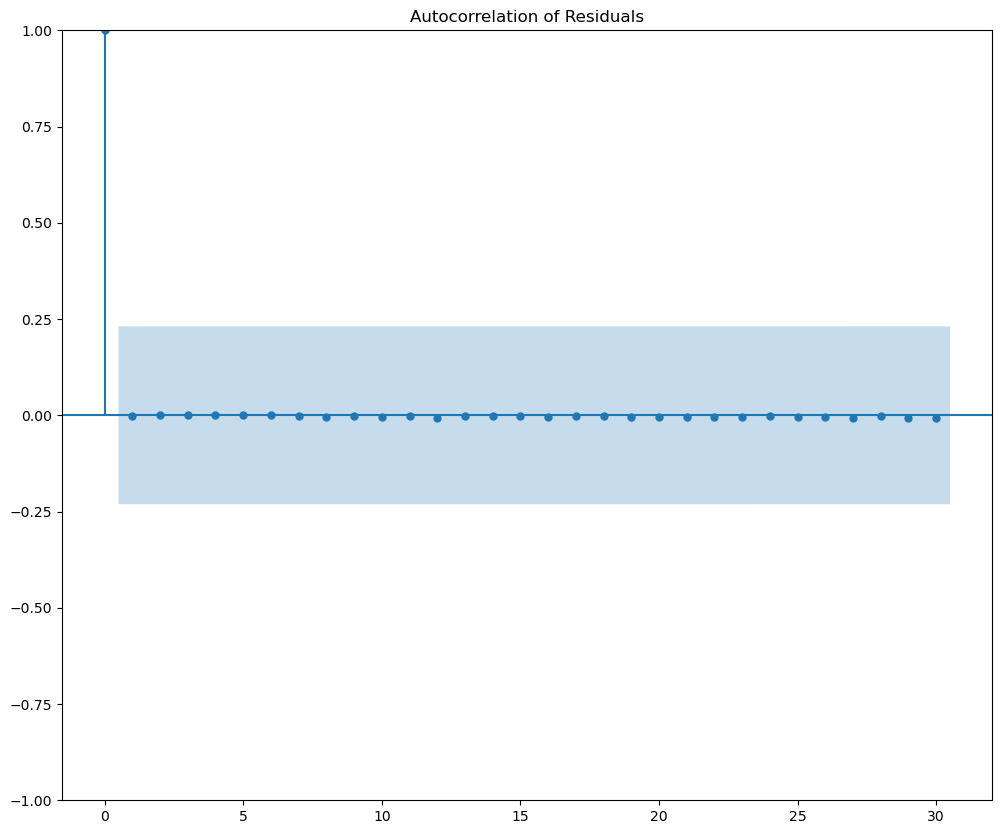

Тест Льюнга-Бокса на автокорреляцию остатков:
Значение статистики =      lb_stat  lb_pvalue
1   0.000628   0.980003
2   0.000882   0.999559
3   0.000883   0.999993
4   0.001041   1.000000
5   0.001126   1.000000
6   0.001129   1.000000
7   0.001518   1.000000
8   0.002612   1.000000
9   0.002707   1.000000
10  0.003904   1.000000
11  0.004582   1.000000
12  0.007836   1.000000
13  0.008558   1.000000
14  0.008773   1.000000
15  0.009307   1.000000
16  0.011262   1.000000
17  0.012154   1.000000
18  0.013126   1.000000
19  0.014234   1.000000
20  0.016324   1.000000
21  0.017721   1.000000
22  0.019093   1.000000
23  0.020843   1.000000
24  0.021763   1.000000
25  0.024711   1.000000
26  0.028389   1.000000
27  0.034436   1.000000
28  0.035035   1.000000
29  0.041611   1.000000
30  0.046044   1.000000
p-value =      lb_stat  lb_pvalue
1   0.000628   0.980003
2   0.000882   0.999559
3   0.000883   0.999993
4   0.001041   1.000000
5   0.001126   1.000000
6   0.001129   1.000000
7   0.0015

In [105]:

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Вычисление остатков модели SARIMA
residuals = sarima_result.resid

# Визуализация автокорреляции остатков
plot_acf(residuals, lags=30)
plt.title("Autocorrelation of Residuals")
plt.show()

# Тест Льюнга-Бокса на автокорреляцию остатков
lb_stat = acorr_ljungbox(residuals, lags=30)
lb_pvalue =acorr_ljungbox(residuals, lags=30)
print("Тест Льюнга-Бокса на автокорреляцию остатков:")
print("Значение статистики =", lb_stat)
print("p-value =", lb_pvalue)


Тест Дики-Фуллера на стационарность остатков:
Статистика теста = -9.568288739880732
p-value = 2.3250002664961906e-16


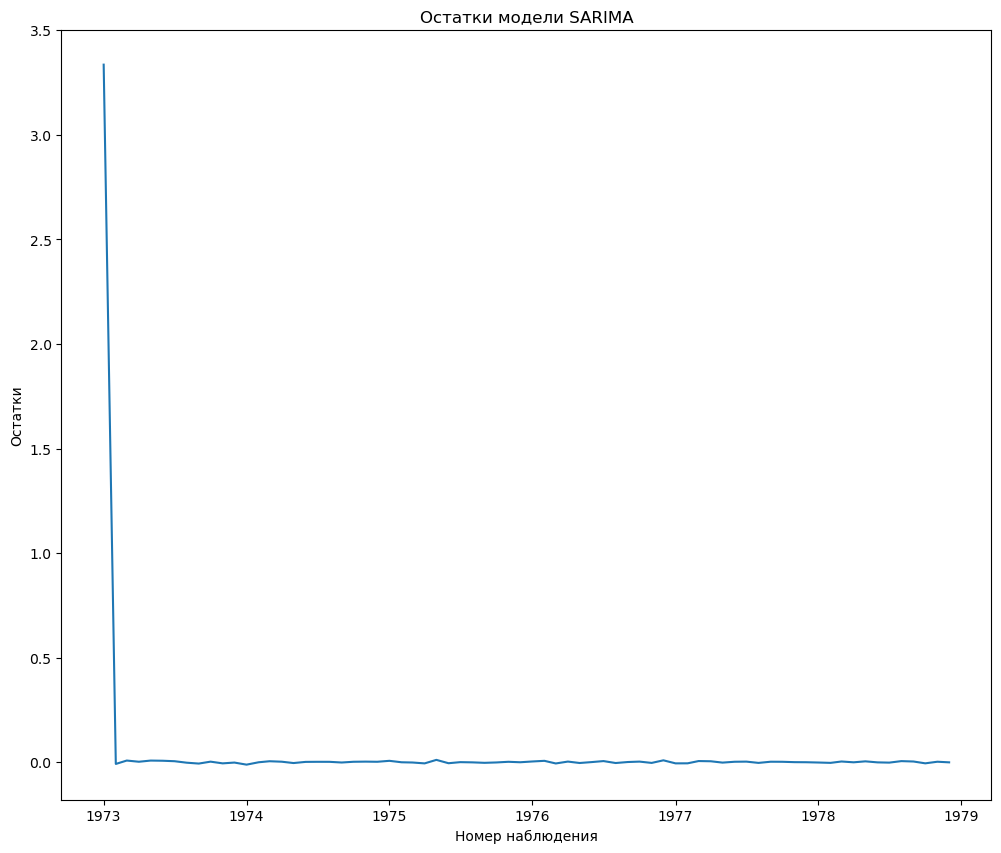

In [117]:
from statsmodels.tsa.stattools import adfuller

# Вычисление остатков модели SARIMA
residuals = sarima_result.resid

# Тест Дики-Фуллера на стационарность остатков
adf_stat, p_value, _, _, _, _ = adfuller(residuals)
print("Тест Дики-Фуллера на стационарность остатков:")
print("Статистика теста =", adf_stat)
print("p-value =", p_value)

# Визуализация остатков
plt.plot(residuals)
plt.title("Остатки модели SARIMA")
plt.xlabel("Номер наблюдения")
plt.ylabel("Остатки")
plt.show()


я хотела тут посмотреть остатки и оценить их, но не понимаю,что получилось.
По Тесту Шапиро-Уилка на нормальность остатков -  остатки не распределены нормально (отвергаем H0)
Тест Льюнга-Бокса на автокорреляцию остатков показал, что все p-значения значительно больше уровня значимости (0.05), нет оснований отвергать нулевую гипотезу о отсутствии автокорреляции в остатках. 
То есть, нет статистически значимых доказательств автокорреляции. 
А результаты теста Дики-Фуллера указывают на то, что нулевая гипотеза о нестационарности остатков отвергается. Остатки являются стационарными

In [142]:
# Оценка модели 

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Разделение данных на обучающий и тестовый наборы
train_data = deaths[:-15]
test_data = deaths[-15:]
test_data = test_data.dropna()
# Обучение модели SARIMA на обучающем наборе
sarima_model = SARIMAX(train_data, order=model.order, seasonal_order=model.seasonal_order)
sarima_result = sarima_model.fit()

# Прогнозирование на тестовом наборе данных
forecast = sarima_result.forecast(steps=len(test_data))

# Оценка производительности модели
mse = mean_squared_error(test_data, forecast)
r2 = r2_score(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)

# Вывод результатов оценки
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Mean Squared Error (MSE): 5.219936024963913e-06
R-squared (R2): 0.9242663735362213
Mean Absolute Error (MAE): 0.0018327950878955631


c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

Мой прогноз :

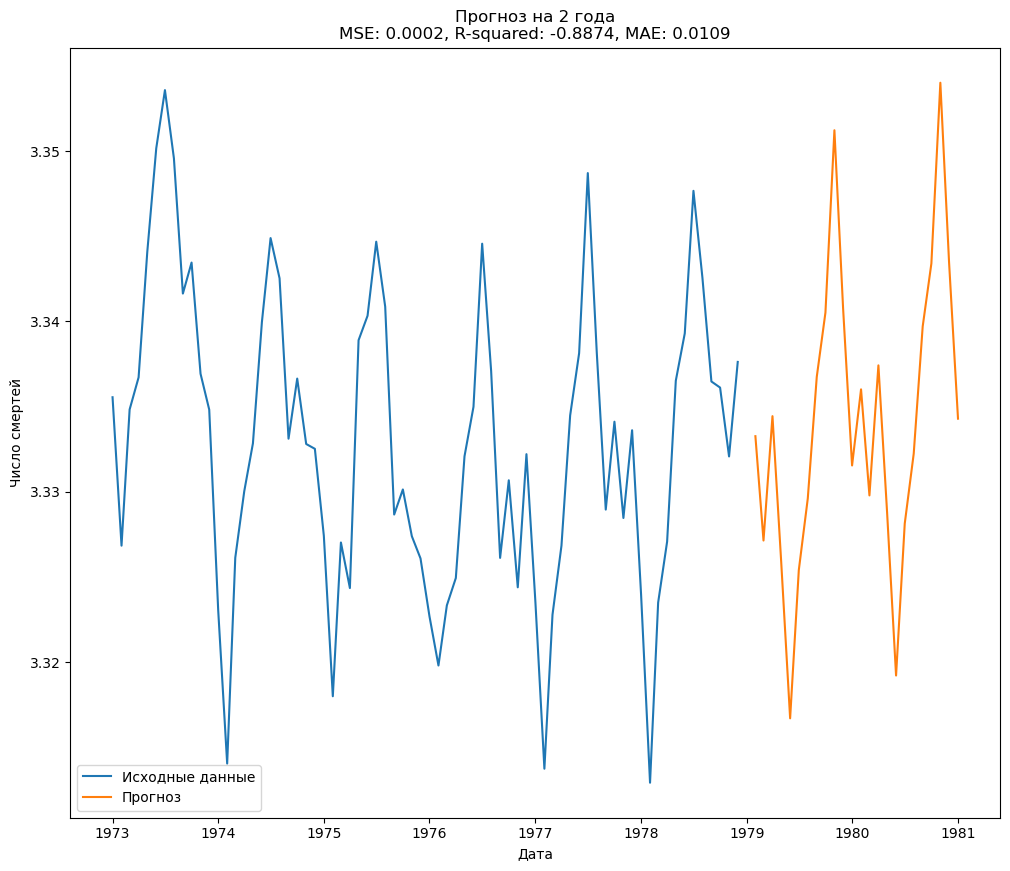

In [149]:
# Прогноз на следующие 24 месяца
forecast = sarima_result.forecast(steps=24)

# Визуализация исходных данных и прогноза с метриками
plt.plot(data.index, data['num_deaths'], label='Исходные данные')
plt.plot(pd.date_range(start=data.index[-1], periods=25, freq='M')[1:], forecast, label='Прогноз')
plt.xlabel('Дата')
plt.ylabel('Число смертей')
plt.title('Прогноз на 2 года\nMSE: {:.4f}, R-squared: {:.4f}, MAE: {:.4f}'.format(mse, r2, mae))
plt.legend()
plt.show()


Вывод:
- для прогноза на 2 года числа смертей подходит SARIMA модель. Она показала хорошие показатели основных метрик.
- уровень смертности останется на +/- таком же уровне